In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders

# # Input folder containing 'decent' and 'indecent' subfolders
# input_folder = "/content/drive/MyDrive/Dataset_Bangkit/data_awal"

# # Output folder where the split data will be stored
# output_folder = "/content/drive/MyDrive/Dataset_Bangkit/data_awal_split"

# # Split with a ratio of 80:20
# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.7, 0.3), group_prefix=None)

In [ ]:
# Define paths
train_dir = '/content/drive/MyDrive/Dataset_Bangkit/data_awal_split/train'
val_dir = '/content/drive/MyDrive/Dataset_Bangkit/data_awal_split/val'

In [ ]:
def train_val_generators(train_dir, val_dir):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)


    train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(256, 256),
      batch_size=32,
      class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 304 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


(32, 256, 256, 3)


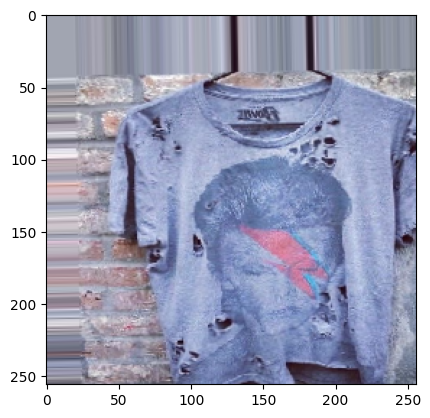

(32, 256, 256, 3)


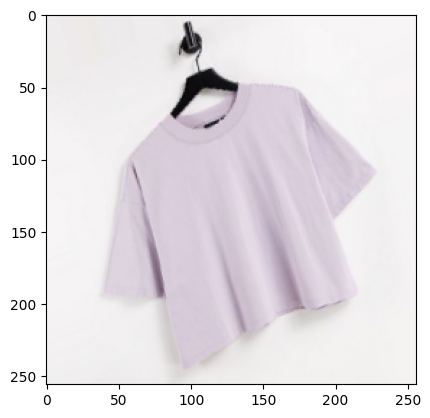

(32, 256, 256, 3)


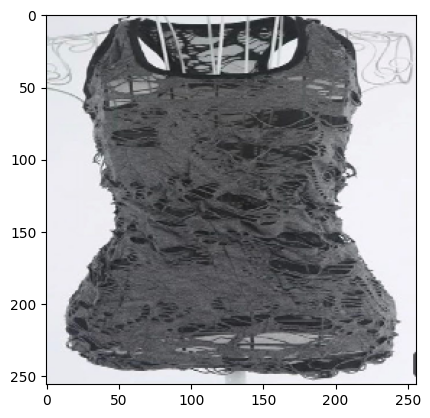

(32, 256, 256, 3)


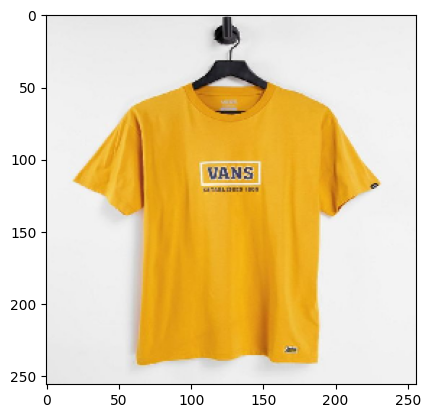

In [ ]:
for _ in range(2):
    img, label = train_generator.next()
    plt.imshow(np.squeeze(img[0]))
    print(img.shape)
    plt.show()

for _ in range(2):
    img, label = validation_generator.next()
    plt.imshow(np.squeeze(img[0]))
    print(img.shape)
    plt.show()

In [ ]:
# Get the class details
class_details = validation_generator.class_indices

# Print the class details
for class_name, class_index in class_details.items():
    print("Class:", class_name)
    print("Index:", class_index)


Class: decent
Index: 0
Class: indecent
Index: 1


In [ ]:
def create_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Add custom callback to stop after accuracy > 99%
class EarlyStoppingByAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None and accuracy > 0.99:
            print(f"\nAccuracy reached {accuracy * 100:.2f}%, stopping training.")
            self.model.stop_training = True

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min'),
    EarlyStoppingByAccuracy()
]

In [ ]:
base_model_mobilenet = MobileNetV2(input_shape=(256, 256, 3),
                                   include_top=False,
                                   weights='imagenet')
for layer in base_model_mobilenet.layers:
  layer.trainable = False
base_model_mobilenet.summary()
model_mobilenet = create_model(base_model_mobilenet)
model_mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[

In [ ]:
history_mobilenet = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
9/9 [==============================] - 36s 4s/step - loss: 0.6515 - accuracy: 0.5919 - val_loss: 0.5015 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 32s 4s/step - loss: 0.4935 - accuracy: 0.7904 - val_loss: 0.4096 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 32s 4s/step - loss: 0.3791 - accuracy: 0.8750 - val_loss: 0.3360 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 32s 3s/step - loss: 0.3084 - accuracy: 0.9338 - val_loss: 0.3035 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 42s 5s/step - loss: 0.3003 - accuracy: 0.9118 - val_loss: 0.2752 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 33s 4s/step - loss: 0.2511 - accuracy: 0.9301 - val_loss: 0.2521 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 34s 4s/step - loss: 0.2323 - accuracy: 0.948

In [ ]:
loss_mobilenet, accuracy_mobilenet = model_mobilenet.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"MobileNetV2 Validation Accuracy: {accuracy_mobilenet * 100:.2f}%")

4/4 [==============================] - 8s 2s/step - loss: 0.1549 - accuracy: 0.9453
MobileNetV2 Validation Accuracy: 94.53%


In [ ]:
base_model_inception = InceptionV3(input_shape=(256, 256, 3),
                                   include_top=False,
                                   weights='imagenet')
for layer in base_model_inception.layers:
  layer.trainable = False
base_model_inception.summary()
model_inception = create_model(base_model_inception)
model_inception.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min'),
    EarlyStoppingByAccuracy()
]

In [ ]:
history_inception = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
9/9 [==============================] - 100s 11s/step - loss: 0.6282 - accuracy: 0.6618 - val_loss: 0.5539 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 73s 8s/step - loss: 0.5058 - accuracy: 0.7610 - val_loss: 0.5392 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 74s 9s/step - loss: 0.4175 - accuracy: 0.8235 - val_loss: 0.4342 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 72s 8s/step - loss: 0.3799 - accuracy: 0.8309 - val_loss: 0.4337 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 73s 8s/step - loss: 0.3515 - accuracy: 0.8272 - val_loss: 0.3927 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 72s 8s/step - loss: 0.3289 - accuracy: 0.8750 - val_loss: 0.3681 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 73s 8s/step - loss: 0.2924 - accuracy: 0.8

In [ ]:
loss_inception, accuracy_inception = model_inception.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"InceptionV3 Validation Accuracy: {accuracy_inception * 100:.2f}%")

4/4 [==============================] - 21s 5s/step - loss: 0.2368 - accuracy: 0.8750
InceptionV3 Validation Accuracy: 87.50%


MobileNetV2 Validation Accuracy: 94.53%
InceptionV3 Validation Accuracy: 87.50%


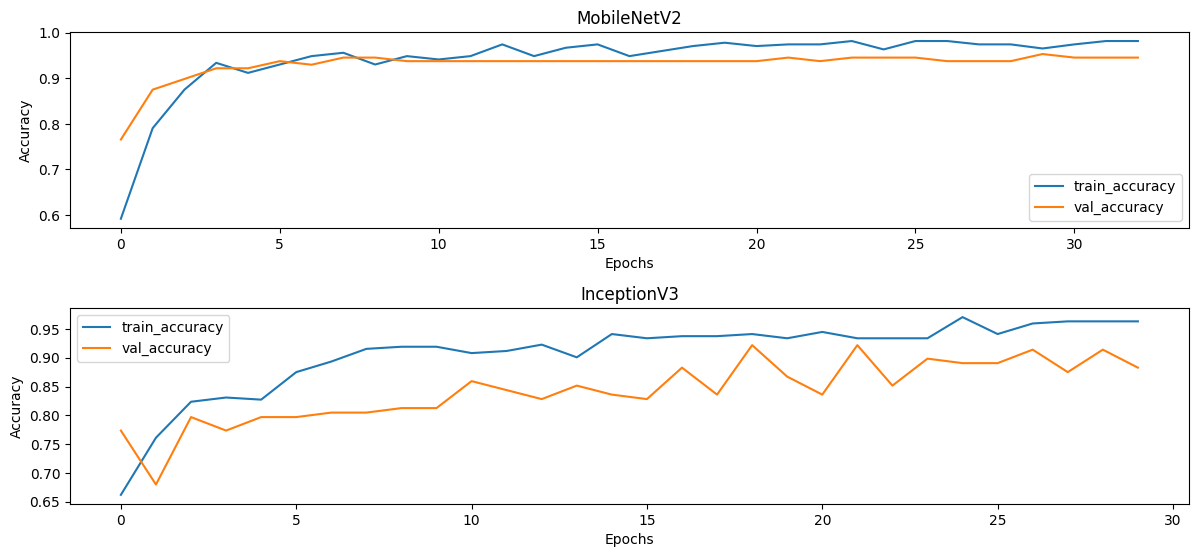

In [ ]:
# Print out the validation accuracies
print(f"MobileNetV2 Validation Accuracy: {accuracy_mobilenet * 100:.2f}%")
print(f"InceptionV3 Validation Accuracy: {accuracy_inception * 100:.2f}%")

# Plot the training history
def plot_history(histories, titles):
    plt.figure(figsize=(12, 8))
    for i, history in enumerate(histories):
        plt.subplot(3, 1, i+1)
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title(titles[i])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history([history_mobilenet, history_inception],
             ['MobileNetV2', 'InceptionV3'])
